![Alt text](https://imgur.com/orZWHly.png=80)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!

In [1]:
# Importando las librerias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Cargando el dataset
penguins_df = pd.read_csv("Datasets/penguins.csv")

# **ANÁLISIS EXPLORATORIO DE DATOS**

Primeramente para entender el dataset hay que revisionar lo que contiene y algunos datos estadísticos básicos de sus variables

In [2]:
#Viendo las primeras 5 filas del dataset
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


**Checando información a cerca de las variables del dataset**

In [3]:
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


**Datos estadísticos básicos de cada columna**

In [4]:
penguins_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


**Para ver la matriz de correlacion es necesario quitar las variables categóticas**

In [5]:
#Eliminando sex
penguins_df.drop("sex", axis=1).corr()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.220570,0.654967,0.593396
culmen_depth_mm,-0.220570,1.000000,-0.580062,-0.476386
flipper_length_mm,0.654967,-0.580062,1.000000,0.873267
body_mass_g,0.593396,-0.476386,0.873267,1.000000


# **PREPROCESADO DE DATOS**

### **CREADNDO VARIABLES DUMMIES PARA "SEX"**

In [6]:
penguins_df = pd.get_dummies(penguins_df, columns=['sex'], drop_first=True)

### **ESTANDARIZANDO VARIABLES NUMÉRICAS CON STANDARDSCALER**

In [7]:
scaler = StandardScaler()
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
penguins_df_sc = penguins_df.copy()
penguins_df_sc[numeric_columns] = scaler.fit_transform(penguins_df[numeric_columns])

### **VERIFICANDO EL MEJOR NÚMERO DE CLUSTERS CON EL MÉTODO ELBOW**

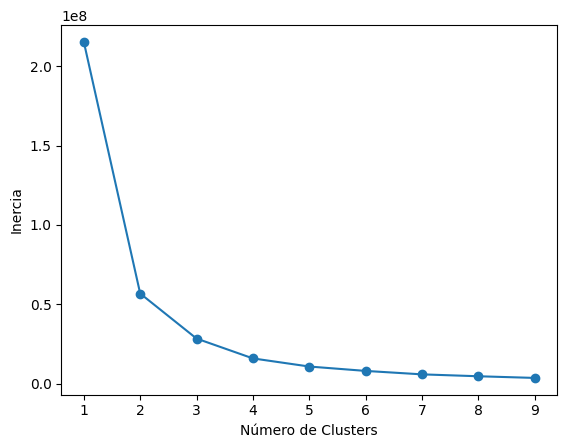

In [8]:
inertia = []
range_clusters = range(1, 10)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(penguins_df[numeric_columns])
    inertia.append(kmeans.inertia_)

plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

El codo claramente esta en 3, esto coincide con el número de especies que se mencionan en el ejercicio, por lo cual utilizaremos este número de clusters para el KMeans

In [9]:
#Ejecutando el algoritmo de KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(penguins_df_sc)

#Agregando las etiquetas de los clusters
penguins_df['label'] = kmeans.labels_
cluster_labels = kmeans.labels_

### **Reducción de dimensionalidad con PCA (Análisis de Componentes Principales)**

In [10]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(penguins_df_sc)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

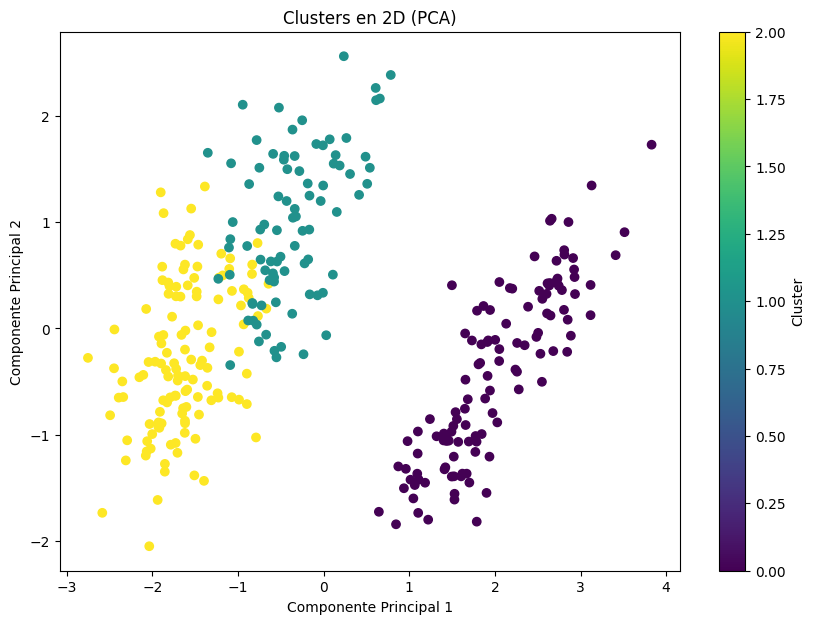

In [11]:
#Graficando
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', marker='o')
plt.title('Clusters en 2D (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# **EVALUACIÓN DEL MODELO**

In [17]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(penguins_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.21194538880390262


In [15]:
stat_penguins = penguins_df.groupby('label').mean()
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
label,,,,,
0,47.568067,14.996639,217.235294,5092.436975,0.512605
1,47.477907,18.787209,197.279070,3918.604651,0.686047
2,38.356693,18.066929,188.244094,3571.259843,0.370079
